#Machine Learning Prediction in Sales for SuperMart

#Import Libraries

In [1]:
!pip install scikit-learn==0.24.1

In [2]:
pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

In [4]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import datetime
from pandas import Series, DataFrame #numerical data back to categorical data

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# Import the regression algorithm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Preprocessing Steps
from sklearn.preprocessing import StandardScaler

#Pipeline
from sklearn.pipeline import Pipeline

SEED = 0 

#Loading the Data

https://datatofish.com/how-to-connect-python-to-sql-server-using-pyodbc/

In [5]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=A0126316\SQLEXPRESS;'
                      'Database=capstone_project1;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

In [6]:
transaction = pd.read_sql_query('SELECT * FROM capstone_project1.dbo.Transactions_Age',conn)
print(transaction.head())
print(type(transaction))

  Transaction_ID   Tran_Date Cust_ID  Age     Category     SubCategory  \
0    10000237880  2013-10-13  271389   25     Footwear  Men's Footwear   
1    10008786951  2012-09-18  267242   27  Electronics       Computers   
2    10011215362  2012-08-26  270641   21     Clothing  Kids' Clothing   
3    10014712375  2013-06-11  270234   38        Books          Comics   
4    10017543415  2014-02-18  267097   41        Books          Comics   

       Store_Type  Qty   Price     Tax  Total_Amt  
0             MBR    1  1200.0  126.00    1326.00  
1        TeleShop    2   512.0  107.52    1131.52  
2        TeleShop    4   936.0  393.12    4137.12  
3        TeleShop    3  1199.0  377.69    3974.69  
4  Flagship store    1   164.0   17.22     181.22  
<class 'pandas.core.frame.DataFrame'>


In [7]:
customer = pd.read_sql_query('SELECT * FROM capstone_project1.dbo.Customer',conn)
print(customer.head())
print(type(customer))

  Customer_ID         DOB Gender  City_Code
0      266783  1974-05-01      M        4.0
1      266784  1991-12-13      F       10.0
2      266785  1985-06-29      F        3.0
3      266788  1972-03-20      F        2.0
4      266794  1971-02-28      F        9.0
<class 'pandas.core.frame.DataFrame'>


In [8]:
transaction_customer = pd.merge(customer, transaction, left_on = 'Customer_ID', right_on = 'Cust_ID')

In [9]:
transaction_customer = transaction_customer.drop('Customer_ID', axis = 1)

In [10]:
transaction_customer = transaction_customer.drop('Transaction_ID', axis = 1)

In [11]:
transaction_customer = transaction_customer.drop('Cust_ID', axis = 1)

In [12]:
transaction_customer = transaction_customer.drop('DOB', axis = 1)

In [13]:
transaction_customer = transaction_customer.drop('City_Code', axis = 1)

In [14]:
#change to datetime format to extract year
transaction_customer['Trans_Date_DT'] = pd.to_datetime(transaction_customer['Tran_Date'], format='%Y-%m-%d')

In [15]:
transaction_customer['Year'] = transaction_customer['Trans_Date_DT'].dt.year

In [16]:
transaction_customer = transaction_customer.drop('Tran_Date', axis = 1)

In [17]:
transaction_customer = transaction_customer.drop('Trans_Date_DT', axis = 1)

In [18]:
transaction_customer.head()

,Gender,Age,Category,SubCategory,Store_Type,Qty,Price,Tax,Total_Amt,Year
0,M,39,Books,Non-Fiction,e-Shop,2,835.0,175.35,1845.35,2013
1,M,39,Clothing,Men's Clothing,e-Shop,1,869.0,91.25,960.25,2013
2,M,38,Clothing,Men's Clothing,TeleShop,3,93.0,29.30,308.30,2012
3,F,21,Books,Fiction,e-Shop,5,176.0,92.40,972.40,2012
4,F,21,Electronics,Mobiles,Flagship store,2,200.0,42.00,442.00,2012


In [19]:
# Interaction Terms

# Price , Year
#transaction_customer['Price_*_Year'] = transaction_customer['Price'] * transaction_customer['Year']

In [20]:
# Interaction Terms

# Price , Age
transaction_customer['Price_*_Age'] = transaction_customer['Price'] * transaction_customer['Age']

In [21]:
transaction_customer['Sales_Amount'] = transaction_customer['Total_Amt']

In [22]:
#https://statisticsbyjim.com/regression/r-squared-too-high/
transaction_customer = transaction_customer.drop('Tax', axis = 1)

In [23]:
#https://statisticsbyjim.com/regression/r-squared-too-high/
transaction_customer = transaction_customer.drop('Price', axis = 1)

In [24]:
transaction_customer = transaction_customer.drop('Total_Amt', axis = 1)

In [25]:
transaction_customer.head()

,Gender,Age,Category,SubCategory,Store_Type,Qty,Year,Price_*_Age,Sales_Amount
0,M,39,Books,Non-Fiction,e-Shop,2,2013,32565.0,1845.35
1,M,39,Clothing,Men's Clothing,e-Shop,1,2013,33891.0,960.25
2,M,38,Clothing,Men's Clothing,TeleShop,3,2012,3534.0,308.30
3,F,21,Books,Fiction,e-Shop,5,2012,3696.0,972.40
4,F,21,Electronics,Mobiles,Flagship store,2,2012,4200.0,442.00


#Data Pre-processing and Exploratory Data Analysis

In [26]:
transaction_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18819 entries, 0 to 18818
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        18812 non-null  object 
 1   Age           18819 non-null  int64  
 2   Category      18819 non-null  object 
 3   SubCategory   18819 non-null  object 
 4   Store_Type    18819 non-null  object 
 5   Qty           18819 non-null  int64  
 6   Year          18819 non-null  int64  
 7   Price_*_Age   18819 non-null  float64
 8   Sales_Amount  18819 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 1.4+ MB


In [27]:
transaction_customer.describe()

,Age,Qty,Year,Price_*_Age,Sales_Amount
count,18819.000000,18819.000000,18819.000000,18819.000000,18819.000000
mean,31.074233,2.998778,2012.115309,24371.663053,2598.615483
std,6.652917,1.420493,0.893160,14195.543371,1958.367392
min,19.000000,1.000000,2011.000000,1463.000000,77.350000
25%,25.000000,2.000000,2011.000000,12672.000000,1025.440000
50%,31.000000,3.000000,2012.000000,23180.000000,2079.610000
75%,37.000000,4.000000,2013.000000,34400.000000,3805.620000
max,44.000000,5.000000,2014.000000,64242.000000,8287.500000


In [28]:
# Clean our data
# Look for any missing values
transaction_customer.isna().any()

Gender           True
Age             False
Category        False
SubCategory     False
Store_Type      False
Qty             False
Year            False
Price_*_Age     False
Sales_Amount    False
dtype: bool

In [29]:
# if have empty data
transaction_customer = transaction_customer.dropna()

In [30]:
# Look for any missing values
transaction_customer.isna().any()

Gender          False
Age             False
Category        False
SubCategory     False
Store_Type      False
Qty             False
Year            False
Price_*_Age     False
Sales_Amount    False
dtype: bool

In [31]:
# count number of items for each unique numerical feature
transaction_customer.nunique()

Gender              2
Age                26
Category            6
SubCategory        23
Store_Type          4
Qty                 5
Year                4
Price_*_Age     11335
Sales_Amount     4147
dtype: int64

###Visualisation

Text(0.5, 1.0, 'Gender')

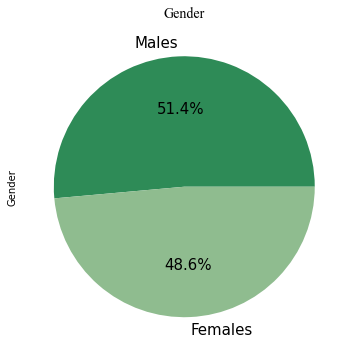

In [32]:
plt.figure(figsize=[12,6])

my_colors = ['seagreen','darkseagreen']
transaction_customer['Gender'].value_counts(normalize=True).plot(kind='pie',labels=['Males','Females'],
                                                           fontsize=15,autopct='%1.1f%%', colors=my_colors)
plt.title('Gender',fontname='Times new roman',fontsize=14)

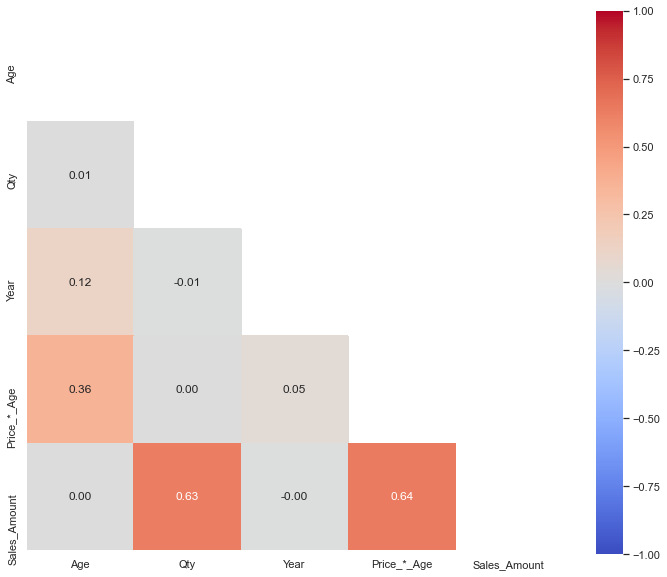

In [33]:
# correlation matrix heatmap visualization
sns.set(style="white")

# Generate a mask for the upper triangle
matrix = np.triu(transaction_customer.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(12,10))

# Plot the heatmap
_ = sns.heatmap(transaction_customer.corr(), mask=matrix, annot=True, annot_kws={"size": 12}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')  # annot=True display corr label

# _ = sns.heatmap(transaction.corr(), annot=True, annot_kws={"size": 12}, square=True, 
#                 cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')

# Prevent Heatmap Cut-Off Issue
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom+0.5, top-0.5)

#Defining the data

In [34]:
transaction_customer.head()

,Gender,Age,Category,SubCategory,Store_Type,Qty,Year,Price_*_Age,Sales_Amount
0,M,39,Books,Non-Fiction,e-Shop,2,2013,32565.0,1845.35
1,M,39,Clothing,Men's Clothing,e-Shop,1,2013,33891.0,960.25
2,M,38,Clothing,Men's Clothing,TeleShop,3,2012,3534.0,308.30
3,F,21,Books,Fiction,e-Shop,5,2012,3696.0,972.40
4,F,21,Electronics,Mobiles,Flagship store,2,2012,4200.0,442.00


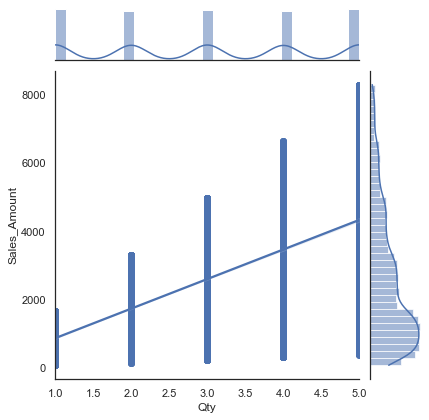

In [35]:
_ = sns.jointplot(x="Qty", y="Sales_Amount", data=transaction_customer, kind="reg")

#####Nominal Data

In [36]:
# Encoding the data - Before training the model, we need to make sure the data is in a form that the model can understand
# Use Label Encoder for all features with 2 classes
#le = LabelEncoder()
#for x in [i for i in transaction_customer.columns if len(transaction_customer[i].unique())==2]:
    #print(x, transaction_customer[x].unique())
    #transaction_customer[x]= le.fit_transform(transaction_customer[x])

In [37]:
# Create dummy variables
dummy_Category = pd.get_dummies(transaction_customer['Category'], prefix='Category')
dummy_SubCategory = pd.get_dummies(transaction_customer['SubCategory'], prefix='SubCategory')
dummy_Store_Type = pd.get_dummies(transaction_customer['Store_Type'], prefix='Store_Type')

to_drop = ['Category', 'SubCategory', 'Store_Type']
transaction_customer.drop(to_drop, axis=1, inplace=True)

In [38]:
# Remap to integers
transaction_customer['Gender'] = [0 if x == 'M' else 1 for x in transaction_customer['Gender']]

In [39]:
# Merge into a single data frame
transaction_customer = pd.concat([dummy_Category, dummy_SubCategory, dummy_Store_Type, transaction_customer], axis=1) 

In [40]:
transaction_customer

,Category_Bags,Category_Books,Category_Clothing,Category_Electronics,Category_Footwear,Category_Home and Kitchen,SubCategory_Academic,SubCategory_Audio and Video,SubCategory_Bath,SubCategory_Cameras,...,Store_Type_Flagship store,Store_Type_MBR,Store_Type_TeleShop,Store_Type_e-Shop,Gender,Age,Qty,Year,Price_*_Age,Sales_Amount
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,39,2,2013,32565.0,1845.35
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,39,1,2013,33891.0,960.25
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,38,3,2012,3534.0,308.30
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,21,5,2012,3696.0,972.40
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,21,2,2012,4200.0,442.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18814,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,20,4,2011,11740.0,2594.54
18815,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,20,5,2011,4420.0,1221.03
18816,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,23,3,2013,16537.0,2383.49
18817,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,21,3,2011,3948.0,623.22


In [41]:
transaction_customer.groupby(by='Sales_Amount').count().sort_values('Sales_Amount', ascending=False).head(10)

,Category_Bags,Category_Books,Category_Clothing,Category_Electronics,Category_Footwear,Category_Home and Kitchen,SubCategory_Academic,SubCategory_Audio and Video,SubCategory_Bath,SubCategory_Cameras,...,SubCategory_Women's Footwear,Store_Type_Flagship store,Store_Type_MBR,Store_Type_TeleShop,Store_Type_e-Shop,Gender,Age,Qty,Year,Price_*_Age
Sales_Amount,,,,,,,,,,,,,,,,,,,,,
8287.50,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
8281.98,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
8276.45,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
8270.93,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
8265.40,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
8259.88,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8254.35,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
8248.83,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
8243.30,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


#Correlation Plot


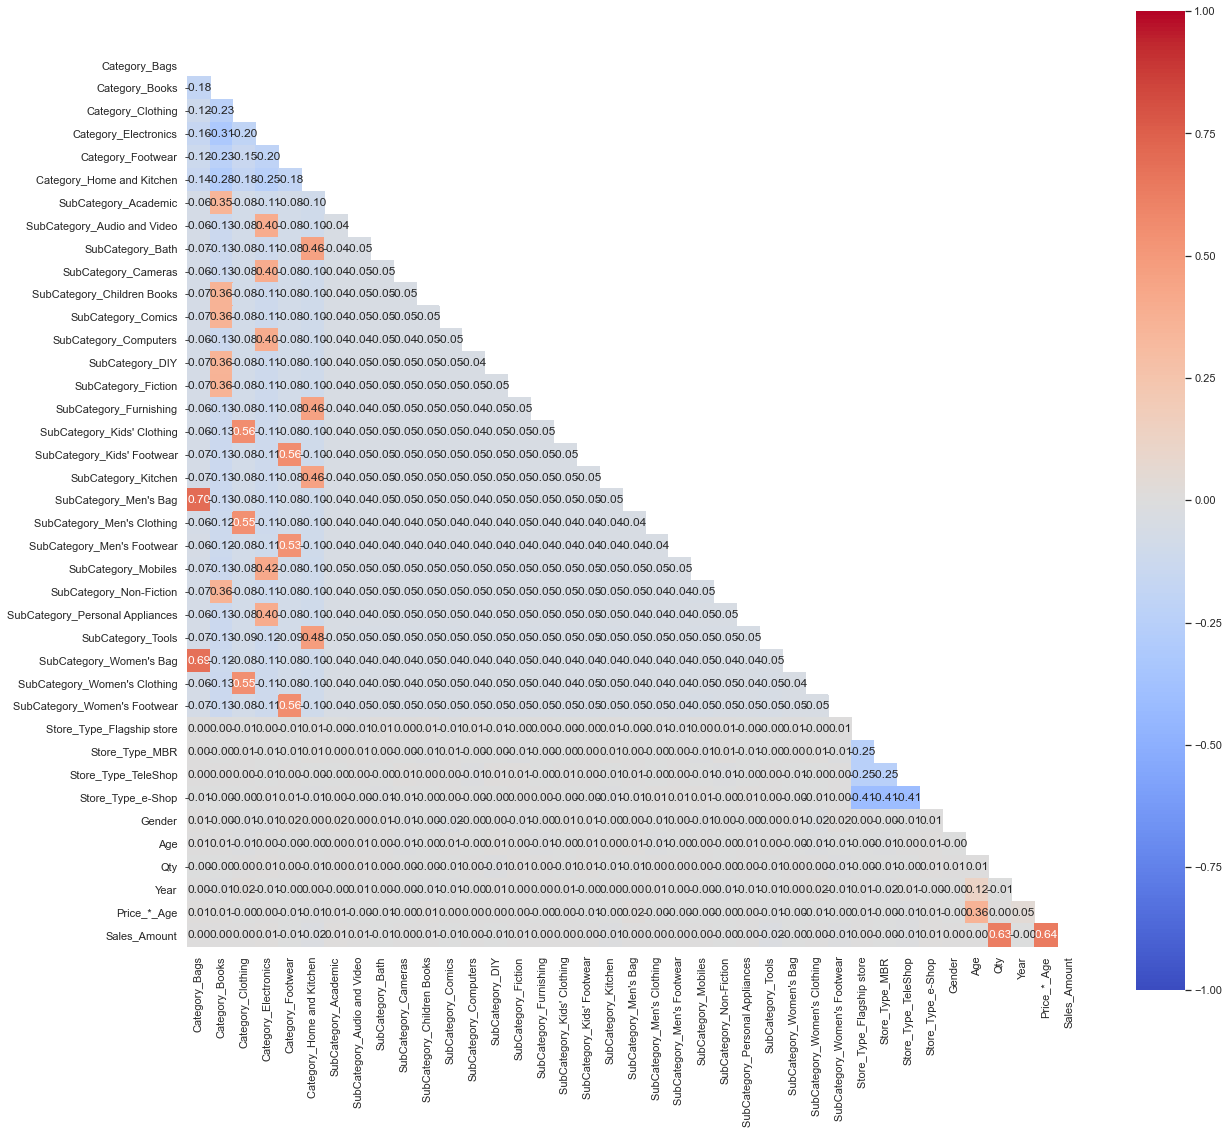

In [42]:
# correlation matrix heatmap visualization
sns.set(style="white")

# Generate a mask for the upper triangle
matrix = np.triu(transaction_customer.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,18))

# Plot the heatmap
_ = sns.heatmap(transaction_customer.corr(), mask=matrix, annot=True, annot_kws={"size": 12}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')  # annot=True display corr label

# _ = sns.heatmap(transaction.corr(), annot=True, annot_kws={"size": 12}, square=True, 
#                 cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')

# Prevent Heatmap Cut-Off Issue
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom+0.5, top-0.5)

# Split the data and train the models

In [43]:
X=transaction_customer.drop('Sales_Amount',axis=1)
y=transaction_customer['Sales_Amount']


In [44]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=False, random_state = SEED) #0.20-20% test data

In [45]:
#train data
#X_train.head(10)
print(len(X_train))

#test data
#X_test.head(10)
print(len(X_test))

15049
3763


In [46]:
# Lists to keep track of model metrics
models = []
mean_squared_error_list = []
r2_list = []
training_variance_list = []
testing_variance_list = []

In [47]:
#Standard Scaler
scaler = StandardScaler()

LIST OF REGRESSION ALGORITHMS IN MACHINE LEARNING
Linear Regression,
Neural Network Regression,
Decision Tree Regression, Random Forest,
KNN Model,
Lasso Regression 
Ridge Regression
https://www.jigsawacademy.com/popular-regression-algorithms-ml/

There are three popular regularization techniques, each of them aiming at decreasing the size of the coefficients:
Ridge Regression, which penalizes sum of squared coefficients (L2 penalty).
Lasso Regression, which penalizes the sum of absolute values of the coefficients (L1 penalty).
Elastic Net, a convex combination of Ridge and Lasso.
https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

#Training the model

##Base Model- Multiple linear regression

In [48]:
#Regressor
#lr = Ridge(alpha=0.1,normalize=True)
lr = LinearRegression()

In [49]:
# build a pipeline with two steps, the scaler and the classifier
regressor = Pipeline([('scaler',scaler),('lr',lr)])

In [50]:
#Mean Squared Error
scores_r2 = cross_val_score(regressor,  
                         X_train, 
                         y_train, cv=5, scoring='r2')

print(scores_r2)
#Note: all scoring functions follow higher return values are better than lower return values
#This is why mean squared error is negated as a scoring function

[0.86262429 0.85617631 0.86621814 0.8700754  0.8606295 ]


In [51]:
# Train the model
regressor.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [52]:
#Testing
# Kept aside some data to test - X_test
y_pred = regressor.predict(X_test)

compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [53]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1085.177952
15057,812.18,645.728703
15058,2324.92,2595.284084
15059,885.11,1025.049325
15060,2629.90,3337.093165
...,...,...
18814,2594.54,3045.638233
18815,1221.03,3146.828499
18816,2383.49,2375.754078
18817,623.22,1291.725913


In [54]:
# The coefficients
print('Coefficients: \n', regressor.named_steps['lr'].coef_)

Coefficients: 
 [-3.13928087e+13 -1.41846426e+15  9.64692000e+14  6.77338123e+15
  3.54178711e+15  6.56938878e+15  1.78921054e+15 -2.12309594e+15
 -2.29742278e+15 -2.08055043e+15  1.88813071e+15  1.92467146e+15
 -2.08691880e+15  1.87989426e+15  1.88813071e+15 -2.27092040e+15
  6.33050165e+14 -9.37934696e+14 -2.27258767e+15  1.25386233e+15
  6.25545312e+14 -8.92727362e+14 -2.19331316e+15  1.92065277e+15
 -2.14013987e+15 -2.37163694e+15  1.23747178e+15  6.31651121e+14
 -9.38599660e+14 -6.80277592e+14 -6.80277592e+14 -6.75989083e+14
 -8.35459659e+14  1.93893343e+00 -5.34614355e+02  1.23050219e+03
  5.33411603e+00  1.44379645e+03]


In [55]:
# The mean squared error
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: {:.2f}'.format(r2_score(y_test, y_pred)))

Mean squared error: 505011.26
Coefficient of determination: 0.87


In [56]:
# Evaluate the model's training score and test score
print("Regression model's training score = {:.2f}".format(regressor.score(X_train, y_train)))
print("Regression model's test score     = {:.2f}".format(regressor.score(X_test, y_test)))

Regression model's training score = 0.86
Regression model's test score     = 0.87


In [57]:
models.append('Baseline- Linear Regression')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, regressor.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

##Multiple linear regression Lasso

In [58]:
#Regressor
#lr = Ridge(alpha=0.1,normalize=True)
lr = linear_model.Lasso(alpha=0.1)

In [59]:
# build a pipeline with two steps, the scaler and the classifier
regressor = Pipeline([('scaler',scaler),('lr',lr)])

In [60]:
#Mean Squared Error
scores_r2 = cross_val_score(regressor,  
                         X_train, 
                         y_train, cv=5, scoring='r2')

print(scores_r2)
#Note: all scoring functions follow higher return values are better than lower return values
#This is why mean squared error is negated as a scoring function

[0.86311768 0.85659187 0.86649828 0.8701483  0.86131187]


In [61]:
# Train the model
regressor.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', Lasso(alpha=0.1))])

In [62]:
#Testing
# Kept aside some data to test - X_test
y_pred = regressor.predict(X_test)

compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [63]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1102.716342
15057,812.18,677.688059
15058,2324.92,2613.255076
15059,885.11,957.638530
15060,2629.90,3327.961024
...,...,...
18814,2594.54,3036.703155
18815,1221.03,3201.671357
18816,2383.49,2409.946225
18817,623.22,1343.828136


In [64]:
# The coefficients
print('Coefficients: \n', regressor.named_steps['lr'].coef_)

Coefficients: 
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.69847828e+00  2.90555940e+00  4.19719710e+00
  2.82375699e+00  8.05863509e+00  1.76657416e+00 -5.68071680e+00
  3.13623759e-01 -2.66906710e+00 -8.65637513e+00 -4.75471493e+00
 -4.14892880e+00  2.56404503e+00 -0.00000000e+00  0.00000000e+00
  1.32841755e+00  1.32993260e+00 -2.96162004e-01  3.31093012e+00
 -3.23405297e+00 -1.67582321e+00 -1.16756290e+01  5.70699599e+00
 -1.05224074e+01 -5.33468792e-02 -3.47683924e+00  0.00000000e+00
  2.00552942e+00  1.15142460e+00 -5.35420049e+02  1.23204064e+03
  4.82046403e+00  1.44402791e+03]


In [65]:
# The mean squared error
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: {:.2f}'.format(r2_score(y_test, y_pred)))

Mean squared error: 502697.24
Coefficient of determination: 0.87


In [66]:
# Evaluate the model's training score and test score
print("Regression model's training score = {:.2f}".format(regressor.score(X_train, y_train)))
print("Regression model's test score     = {:.2f}".format(regressor.score(X_test, y_test)))

Regression model's training score = 0.86
Regression model's test score     = 0.87


In [67]:
models.append('Lasso- Linear Regression')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, regressor.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

##Multiple linear regression Ridge

In [68]:
#Regressor
lr = Ridge(alpha=0.1,normalize=True)
#lr = linear_model.Lasso(alpha=0.1)

In [69]:
# build a pipeline with two steps, the scaler and the classifier
regressor = Pipeline([('scaler',scaler),('lr',lr)])

In [70]:
#Mean Squared Error
scores_r2 = cross_val_score(regressor,  
                         X_train, 
                         y_train, cv=5, scoring='r2')

print(scores_r2)
#Note: all scoring functions follow higher return values are better than lower return values
#This is why mean squared error is negated as a scoring function

[0.85135467 0.85006473 0.85428869 0.85736214 0.85464907]


In [71]:
# Train the model
regressor.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', Ridge(alpha=0.1, normalize=True))])

In [72]:
#Testing
# Kept aside some data to test - X_test
y_pred = regressor.predict(X_test)

compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [73]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1236.944813
15057,812.18,849.258911
15058,2324.92,2634.155396
15059,885.11,1119.765676
15060,2629.90,3272.957503
...,...,...
18814,2594.54,2922.419929
18815,1221.03,3103.182779
18816,2383.49,2376.837240
18817,623.22,1440.556698


In [74]:
# The coefficients
print('Coefficients: \n', regressor.named_steps['lr'].coef_)

Coefficients: 
 [-2.40989544e+00  6.95641245e-01  3.46733289e+00  4.40209769e+00
 -1.18576798e+00 -5.75466568e+00  5.51500577e+00  4.21474003e+00
  3.08629038e-01  7.15252958e+00  4.41295590e+00 -4.38931373e+00
  1.44982870e+00 -2.94018544e+00 -4.68136518e+00 -3.81508586e+00
 -2.73054253e+00  4.29005545e+00 -1.31375236e+00  4.00591829e+00
  3.28595185e+00  3.01991612e+00 -5.33582287e-01  3.87078578e+00
 -3.15666186e+00 -5.75566521e+00 -7.41103137e+00  5.19968619e+00
 -9.08643962e+00  1.23051427e+00 -4.03192950e+00 -8.80306227e-01
  2.99334310e+00  2.00303459e+00 -4.29731005e+02  1.11911228e+03
 -1.52814708e+00  1.27717600e+03]


In [75]:
# The mean squared error
print('Mean squared error: {:.2f}'.format(mean_squared_error(y_test, y_pred)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: {:.2f}'.format(r2_score(y_test, y_pred)))

Mean squared error: 536539.52
Coefficient of determination: 0.86


In [76]:
# Evaluate the model's training score and test score
print("Regression model's training score = {:.2f}".format(regressor.score(X_train, y_train)))
print("Regression model's test score     = {:.2f}".format(regressor.score(X_test, y_test)))

Regression model's training score = 0.85
Regression model's test score     = 0.86


In [77]:
models.append('Ridge- Linear Regression')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, regressor.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

####Coefficient importance

In [78]:
# get importance
importance = regressor.named_steps['lr'].coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -2.40990
Feature: 1, Score: 0.69564
Feature: 2, Score: 3.46733
Feature: 3, Score: 4.40210
Feature: 4, Score: -1.18577
Feature: 5, Score: -5.75467
Feature: 6, Score: 5.51501
Feature: 7, Score: 4.21474
Feature: 8, Score: 0.30863
Feature: 9, Score: 7.15253
Feature: 10, Score: 4.41296
Feature: 11, Score: -4.38931
Feature: 12, Score: 1.44983
Feature: 13, Score: -2.94019
Feature: 14, Score: -4.68137
Feature: 15, Score: -3.81509
Feature: 16, Score: -2.73054
Feature: 17, Score: 4.29006
Feature: 18, Score: -1.31375
Feature: 19, Score: 4.00592
Feature: 20, Score: 3.28595
Feature: 21, Score: 3.01992
Feature: 22, Score: -0.53358
Feature: 23, Score: 3.87079
Feature: 24, Score: -3.15666
Feature: 25, Score: -5.75567
Feature: 26, Score: -7.41103
Feature: 27, Score: 5.19969
Feature: 28, Score: -9.08644
Feature: 29, Score: 1.23051
Feature: 30, Score: -4.03193
Feature: 31, Score: -0.88031
Feature: 32, Score: 2.99334
Feature: 33, Score: 2.00303
Feature: 34, Score: -429.73100
Feature: 35

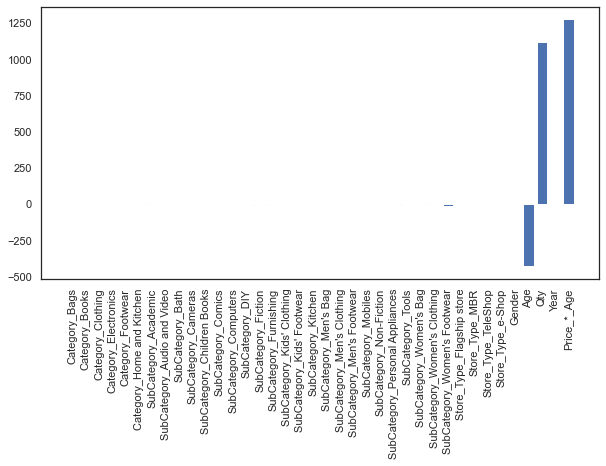

In [79]:
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
plt.figure(figsize=(10,5))
plt.bar([x for x in X], importance)
plt.xticks(rotation=90)
plt.show()

##Decision Tree

In [80]:
# Decision Tree 
dt = DecisionTreeRegressor(random_state=SEED)

In [81]:
#Create Pipeline
dt_reg = Pipeline([('scaler',scaler),('dt',dt)])

In [82]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
#'gini', 'entropy'
#optimising the parameter, best value for best model

param_grid = {'dt__criterion': ['mse', 'mae'],
              'dt__max_depth': [5, 10, 15, 20],
              'dt__min_samples_split': [2, 3, 5]}
              
gs_dt = GridSearchCV(dt_reg,
                      param_grid, 
                      cv=10,
                      scoring='r2',
                      n_jobs=-1)
gs_dt.fit(X_train, y_train)

Wall time: 11min 46s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt',
                                        DecisionTreeRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['mse', 'mae'],
                         'dt__max_depth': [5, 10, 15, 20],
                         'dt__min_samples_split': [2, 3, 5]},
             scoring='r2')

In [83]:
# Best model hyperparameters and score
print(gs_dt.best_estimator_)
print(gs_dt.best_params_)
print(gs_dt.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeRegressor(max_depth=20, min_samples_split=3,
                                       random_state=0))])
{'dt__criterion': 'mse', 'dt__max_depth': 20, 'dt__min_samples_split': 3}
0.9984540564598566


In [84]:
# Using best estimator found by GridSearchCV
dt = gs_dt.best_estimator_
dt.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dt',
                 DecisionTreeRegressor(max_depth=20, min_samples_split=3,
                                       random_state=0))])

In [85]:
y_pred = dt.predict(X_test)

In [86]:
compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [87]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1185.665
15057,812.18,802.230
15058,2324.92,2389.010
15059,885.11,867.425
15060,2629.90,2530.450
...,...,...
18814,2594.54,2576.860
18815,1221.03,1204.450
18816,2383.49,2376.860
18817,623.22,689.520


In [88]:
models.append('Decision Tree')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, dt.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

##Random Forest

In [89]:
# Random Forest
rf = RandomForestRegressor(n_jobs=-1, random_state = SEED)

In [90]:
#Create Pipeline
rf = Pipeline([('scaler',scaler),('rf',rf)])

In [91]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {   
              'rf__n_estimators': [100, 200, 300], 
              'rf__max_features': ["auto", "sqrt"], 
              'rf__max_depth': [5, 10, 25]
              }
              
#'min_samples_split': [5, 10, 15]

gs_rf = GridSearchCV(rf,
                    param_grid, 
                    cv=10,
                    scoring='r2',
                    n_jobs=-1)
gs_rf.fit(X_train, y_train)


Wall time: 8min 34s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=0))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 25],
                         'rf__max_features': ['auto', 'sqrt'],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='r2')

In [92]:
#gs_rf.cv_results_

In [93]:
# Best model hyperparameters and score
print(gs_rf.best_estimator_)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=25, n_estimators=300,
                                       n_jobs=-1, random_state=0))])
{'rf__max_depth': 25, 'rf__max_features': 'auto', 'rf__n_estimators': 300}
0.9995848442547037


In [94]:
# Using best estimator found by GridSearchCV
rf = gs_rf.best_estimator_
rf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=25, n_estimators=300,
                                       n_jobs=-1, random_state=0))])

In [95]:
y_pred = rf.predict(X_test)

In [96]:
compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [97]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1231.043667
15057,812.18,812.306033
15058,2324.92,2368.515933
15059,885.11,881.291333
15060,2629.90,2621.082167
...,...,...
18814,2594.54,2546.689833
18815,1221.03,1236.387833
18816,2383.49,2341.840833
18817,623.22,622.178500


In [98]:
models.append('Random Forest')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, rf.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

In [99]:
# Creating the feature importances dataframe for random forest only
feature_importance = np.array(rf.named_steps['rf'].feature_importances_)
feature_names = np.array(X.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = feat_imp.sort_values('feature_importance', ascending=False)

<AxesSubplot:xlabel='feature_importance', ylabel='feature_names'>

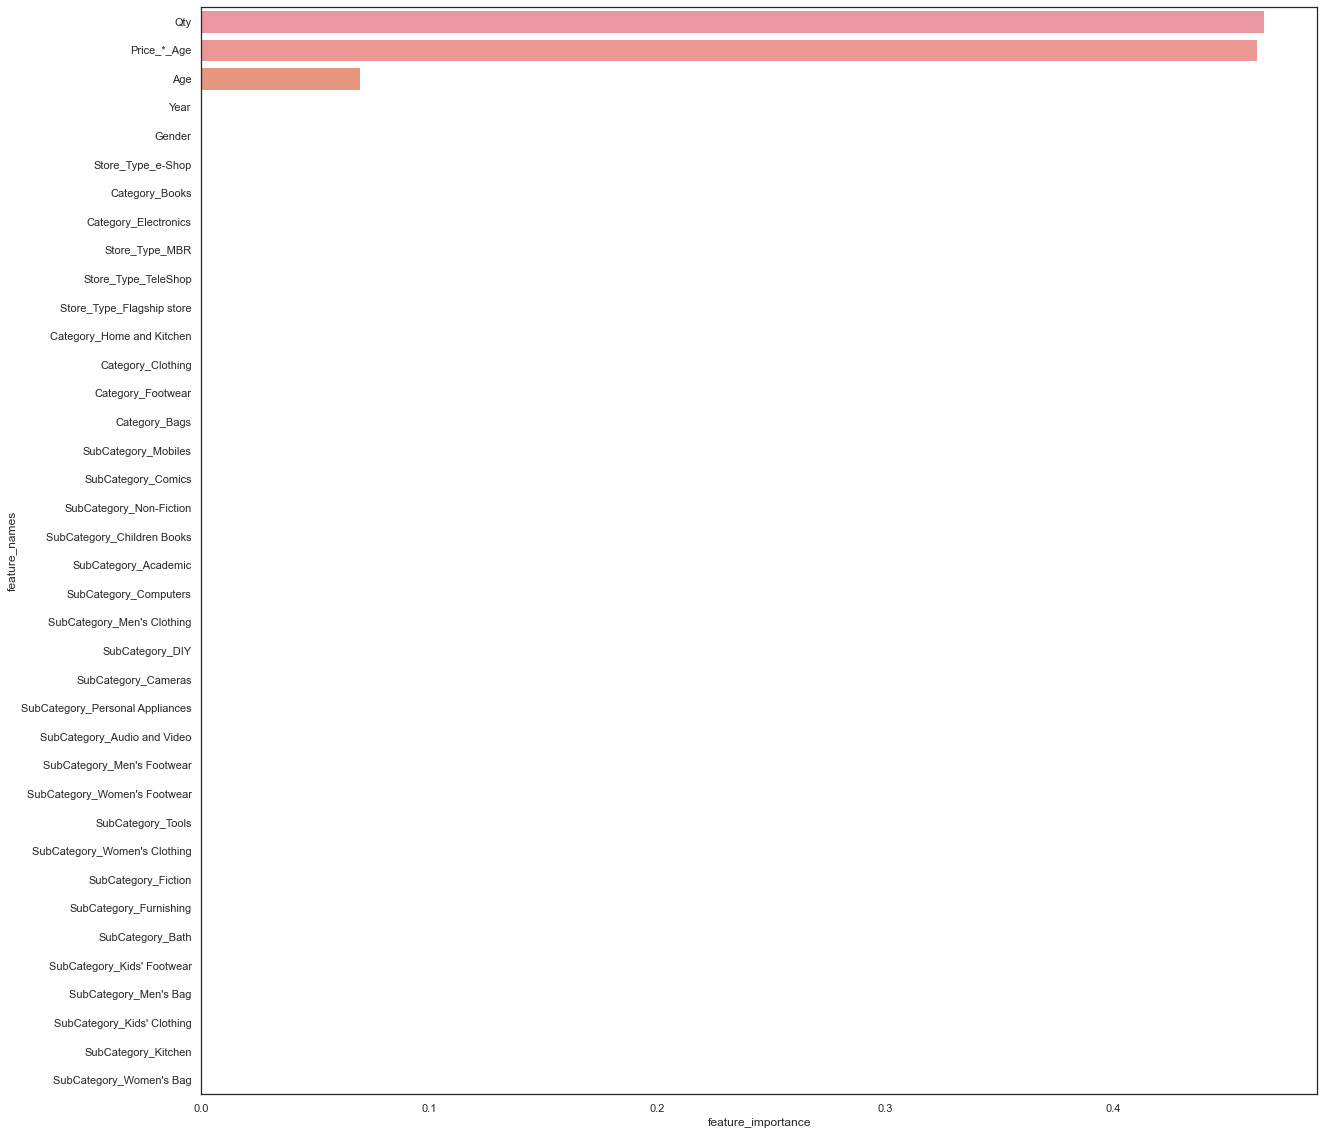

In [100]:
plt.figure(figsize=(20,20))
sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'])

##K-nearest neighnors

In [101]:
# KNeighborsRegressor
KNN = KNeighborsRegressor()

In [102]:
#Create Pipeline
KNN_reg = Pipeline([('scaler',scaler),('KNN',KNN)])

In [103]:
%%time
# Hyperparameter tuning using K-fold cross validation
#optimising the parameter, best value for best model

param_grid = {'KNN__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
              
gs_KNN = GridSearchCV(KNN_reg,
                      param_grid, 
                      cv=10,
                      scoring='r2',
                      n_jobs=-1)
gs_KNN.fit(X_train, y_train)

Wall time: 36.5 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'KNN__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             scoring='r2')

In [104]:
# Best model hyperparameters and score
print(gs_KNN.best_estimator_)
print(gs_KNN.best_params_)
print(gs_KNN.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN', KNeighborsRegressor(n_neighbors=4))])
{'KNN__n_neighbors': 4}
0.8221005388401166


In [105]:
# Using best estimator found by GridSearchCV
KNN = gs_KNN.best_estimator_
KNN.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN', KNeighborsRegressor(n_neighbors=4))])

In [106]:
y_pred = KNN.predict(X_test)

In [107]:
compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [108]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,2058.3400
15057,812.18,1256.3875
15058,2324.92,1238.9850
15059,885.11,962.7325
15060,2629.90,5200.4075
...,...,...
18814,2594.54,3287.1000
18815,1221.03,1964.6900
18816,2383.49,1834.5775
18817,623.22,1158.0425


In [109]:
models.append('KNN')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, KNN.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

##Multi-Level Perceptron - Neural Network

In [110]:
# Multi-Level Perceptron
mlp = MLPRegressor(random_state=SEED)

In [111]:
#Create Pipeline
mlp_reg = Pipeline([('scaler',scaler),('mlp',mlp)])

In [112]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
#param_grid = {'mlp__hidden_layer_sizes': [(3,3),(2),(3)], 
              #'mlp__alpha': np.logspace(-4, -1, 4),
              #'mlp__max_iter': [400, 450, 500, 550]}

#to try        
param_grid = [
        {
            'mlp__activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'mlp__solver' : ['lbfgs', 'sgd', 'adam'],
            'mlp__hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,)
             ]
        }
       ]

gs_mlp = GridSearchCV(mlp_reg,
                      param_grid, 
                      cv=10,
                      scoring='r2',
                      n_jobs=-1)
gs_mlp.fit(X_train, y_train)

C:\Users\mich\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 0.86360567         nan -1.1121417   0.86360567         nan -0.58832116
  0.86360561         nan -0.18464847  0.86360566         nan  0.11685953
  0.86360568         nan  0.34494882  0.66121807  0.60946254 -1.72945588
  0.79254517  0.73690817 -1.71355085  0.85353742  0.82019753 -1.69273339
  0.84048149  0.85467688 -1.67421027  0.88202796  0.87401505 -1.65835259
  0.51469022  0.42526509 -1.73451989  0.67293714  0.70910814 -1.71756844
  0.77964559  0.74695531 -1.70653563  0.79634055  0.75407409 -1.69143455
  0.85105792  0.8160638  -1.67726363  0.9304875          nan -0.82510428
  0.94807493         nan -1.74898131  0.94945253         nan  0.12596667
  0.95354066         nan  0.35038345  0.95016405         nan -0.21876605]
  warnings.warn(


Wall time: 14min 24s


C:\Users\mich\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp', MLPRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid=[{'mlp__activation': ['identity', 'logistic', 'tanh',
                                              'relu'],
                          'mlp__hidden_layer_sizes': [(1,), (2,), (3,), (4,),
                                                      (5,)],
                          'mlp__solver': ['lbfgs', 'sgd', 'adam']}],
             scoring='r2')

In [113]:
# Best model hyperparameters and score
print(gs_mlp.best_estimator_)
print(gs_mlp.best_params_)
print(gs_mlp.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(4,), random_state=0,
                              solver='lbfgs'))])
{'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (4,), 'mlp__solver': 'lbfgs'}
0.9535406608347465


In [114]:
# Using best estimator found by GridSearchCV
mlp = gs_mlp.best_estimator_
mlp.fit(X_train, y_train)

C:\Users\mich\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(4,), random_state=0,
                              solver='lbfgs'))])

In [115]:
y_pred = mlp.predict(X_test)

In [116]:
compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [117]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1099.957754
15057,812.18,854.731112
15058,2324.92,2099.389859
15059,885.11,1045.170477
15060,2629.90,2729.980094
...,...,...
18814,2594.54,2886.384840
18815,1221.03,2922.804424
18816,2383.49,1725.500399
18817,623.22,1115.809094


In [118]:
models.append('Multilevel Perceptron')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, mlp.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

##Gradient Boosting 

https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d
https://educationalresearchtechniques.com/2019/01/14/gradient-boosting-regression-in-python/

In [119]:
gbr = GradientBoostingRegressor(random_state = SEED)

In [120]:
#Create Pipeline
gbreg = Pipeline([('scaler',scaler),('gbr',gbr)])

In [121]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
#,'xgbr__subsample':[.5,.75,1]
#'xgbr__learning_rate':[.001,0.01,.1],
search_grid={'gbr__n_estimators':[500,1000,2000],'gbr__max_depth':[1,2,4]}

gs_gb = GridSearchCV(gbreg,
                      search_grid, 
                      cv=10,
                      scoring='r2',
                      n_jobs=-1)
gs_gb.fit(X_train, y_train)

Wall time: 12min 11s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbr',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'gbr__max_depth': [1, 2, 4],
                         'gbr__n_estimators': [500, 1000, 2000]},
             scoring='r2')

In [122]:
# Best model hyperparameters and score
print(gs_gb.best_estimator_)
print(gs_gb.best_params_)
print(gs_gb.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(max_depth=4, n_estimators=2000,
                                           random_state=0))])
{'gbr__max_depth': 4, 'gbr__n_estimators': 2000}
0.9997230880503254


In [123]:
# Using best estimator found by GridSearchCV
gb = gs_gb.best_estimator_
gb.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(max_depth=4, n_estimators=2000,
                                           random_state=0))])

In [124]:
y_pred = gb.predict(X_test)

In [125]:
compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [126]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1240.527833
15057,812.18,781.199703
15058,2324.92,2371.532907
15059,885.11,890.051719
15060,2629.90,2688.098524
...,...,...
18814,2594.54,2620.594705
18815,1221.03,1235.932031
18816,2383.49,2290.631233
18817,623.22,600.329900


In [127]:
models.append('Gradient Boosting')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, gb.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

##Extreme Gradient Boosting

In [128]:
xgbr = XGBRegressor(random_state=SEED)

In [129]:
#Create Pipeline
xgbreg = Pipeline([('scaler',scaler),('xgbr',xgbr)])

In [130]:
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
gs_xgb = GridSearchCV(xgbreg,  
                    param_grid={'xgbr__n_estimators': [2000, 3000],
                                'xgbr__learning_rate' : [0.01, 0.05],                                
                                'xgbr__min_child_weight' : [0, 1]
                               },
                    cv = 10,
                    scoring = 'r2',
                    n_jobs=-1)
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgbr',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                           

In [131]:
# Best model hyperparameters and score
print(gs_xgb.best_estimator_)
print(gs_xgb.best_params_)
print(gs_xgb.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=6, min_child_weight=0,
                              missing=nan, monotone_constraints='()',
                              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])
{'xgbr__learning_rate': 0.05, 'xgbr__min_child_weight': 0, 'xgbr__n_estimators': 3000}
0.9997815241995

In [132]:
# Using best estimator found by GridSearchCV
xgb = gs_xgb.best_estimator_
xgb.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=6, min_child_weight=0,
                              missing=nan, monotone_constraints='()',
                              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [133]:
y_pred = xgb.predict(X_test)

In [134]:
compare_df = pd.DataFrame({"Desired Output (Actuals)": y_test, 
                           "Predicted Output": y_pred})

In [135]:
compare_df

,Desired Output (Actuals),Predicted Output
15056,1239.81,1267.171875
15057,812.18,810.945068
15058,2324.92,2355.137695
15059,885.11,884.453125
15060,2629.90,2635.295898
...,...,...
18814,2594.54,2621.624268
18815,1221.03,1219.926270
18816,2383.49,2335.338379
18817,623.22,610.265930


In [136]:
models.append('Extreme Gradient Boosting')
mean_squared_error_list.append(mean_squared_error(y_test, y_pred))
training_variance_list.append(explained_variance_score(y_train, xgb.predict(X_train)))
testing_variance_list.append(explained_variance_score(y_test, y_pred))
r2_list.append(r2_score(y_test, y_pred))

#Model Performance Summary

In [137]:
model_metrics = pd.DataFrame(zip(models, training_variance_list, testing_variance_list,
                                mean_squared_error_list, r2_list), 
                             columns=['Model', 'Training Variance', 'Testing Variance', 'Mean Square Error', 'R2'])

In [138]:
model_metrics.sort_values(by='R2', ascending=False)

,Model,Training Variance,Testing Variance,Mean Square Error,R2
8,Extreme Gradient Boosting,0.999978,0.999819,699.853837,0.999819
7,Gradient Boosting,0.999908,0.999752,961.296706,0.999752
4,Random Forest,0.999949,0.999641,1390.453929,0.999641
3,Decision Tree,0.999977,0.998542,5651.038443,0.998542
6,Multilevel Perceptron,0.954503,0.956739,167655.330161,0.956729
1,Lasso- Linear Regression,0.864388,0.870283,502697.240610,0.870258
0,Baseline- Linear Regression,0.864078,0.869686,505011.256143,0.869660
2,Ridge- Linear Regression,0.854316,0.861528,536539.523185,0.861523
5,KNN,0.903904,0.836228,634550.499092,0.836227


#Predict and Evaluate with the best model

###Future Prediction

https://www.kite.com/python/answers/how-to-convert-a-numpy-array-of-floats-into-integers-in-python

In [139]:
my_features = X_test.iloc[0]
own_pred = xgb.predict(X_test.iloc[[0]])
my_features = my_features.astype(int)
print("My target value is   =", round(own_pred[0],2))
print("My observed value is =", str(y_test.iloc[0]))
print(my_features)

My target value is   = 1267.17
My observed value is = 1239.81
Category_Bags                          0
Category_Books                         0
Category_Clothing                      0
Category_Electronics                   0
Category_Footwear                      1
Category_Home and Kitchen              0
SubCategory_Academic                   0
SubCategory_Audio and Video            0
SubCategory_Bath                       0
SubCategory_Cameras                    0
SubCategory_Children Books             0
SubCategory_Comics                     0
SubCategory_Computers                  0
SubCategory_DIY                        0
SubCategory_Fiction                    0
SubCategory_Furnishing                 0
SubCategory_Kids' Clothing             0
SubCategory_Kids' Footwear             0
SubCategory_Kitchen                    0
SubCategory_Men's Bag                  0
SubCategory_Men's Clothing             0
SubCategory_Men's Footwear             1
SubCategory_Mobiles                 

With 1 random data for prediction

In [143]:
my_features = X_test.iloc[np.random.randint(0, len(X_test))]
own_pred = xgb.predict(my_features.to_numpy().reshape(1,-1))
my_features = my_features.astype(int)
print("My target value is   =", str(round(own_pred[0], 2)))
print("This was the input data:")
print(my_features)

My target value is   = 833.47
This was the input data:
Category_Bags                          0
Category_Books                         1
Category_Clothing                      0
Category_Electronics                   0
Category_Footwear                      0
Category_Home and Kitchen              0
SubCategory_Academic                   0
SubCategory_Audio and Video            0
SubCategory_Bath                       0
SubCategory_Cameras                    0
SubCategory_Children Books             0
SubCategory_Comics                     0
SubCategory_Computers                  0
SubCategory_DIY                        0
SubCategory_Fiction                    0
SubCategory_Furnishing                 0
SubCategory_Kids' Clothing             0
SubCategory_Kids' Footwear             0
SubCategory_Kitchen                    0
SubCategory_Men's Bag                  0
SubCategory_Men's Clothing             0
SubCategory_Men's Footwear             0
SubCategory_Mobiles                    0
Su

https://stackoverflow.com/questions/59406045/convert-pandas-series-into-a-row

In [144]:
#into data frame
my_features = X_test.iloc[np.random.randint(0, len(X_test))]
own_pred = xgb.predict(my_features.to_numpy().reshape(1,-1))
my_features = my_features.astype(int)
s = my_features.sort_index()
#become dataframe
df = s.to_frame().T
#add prediction column
df["Predicted"] = str(round(own_pred[0], 2))
print(df)

       Age  Category_Bags  Category_Books  Category_Clothing  \
17548   36              0               0                  0   

       Category_Electronics  Category_Footwear  Category_Home and Kitchen  \
17548                     0                  0                          1   

       Gender  Price_*_Age  Qty  ...  SubCategory_Men's Footwear  \
17548       0        18504    2  ...                           0   

       SubCategory_Mobiles  SubCategory_Non-Fiction  \
17548                    0                        0   

       SubCategory_Personal Appliances  SubCategory_Tools  \
17548                                0                  1   

       SubCategory_Women's Bag  SubCategory_Women's Clothing  \
17548                        0                             0   

       SubCategory_Women's Footwear  Year  Predicted  
17548                             0  2013    1139.96  

[1 rows x 39 columns]


With 10 random data for prediction

https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop

In [148]:
num = 10
data = []
for own_pred in range(num):
    my_features = X_test.iloc[np.random.randint(0, len(X_test))]
    own_pred = xgb.predict(my_features.to_numpy().reshape(1,-1))
    my_features = my_features.astype(int)
    s = my_features.sort_index()
    df = s.to_frame().T
    #add prediction column
    df["Predicted"] = str(round(own_pred[0], 2))
    #add the prediction column inside the df
    data.append(df)
#Add the 10 loops together    
data = pd.concat(data)

In [149]:
data.head()

,Age,Category_Bags,Category_Books,Category_Clothing,Category_Electronics,Category_Footwear,Category_Home and Kitchen,Gender,Price_*_Age,Qty,...,SubCategory_Men's Footwear,SubCategory_Mobiles,SubCategory_Non-Fiction,SubCategory_Personal Appliances,SubCategory_Tools,SubCategory_Women's Bag,SubCategory_Women's Clothing,SubCategory_Women's Footwear,Year,Predicted
17644,38,0,1,0,0,0,0,1,53352,2,...,0,0,1,0,0,0,0,0,2014,3108.46
15212,38,1,0,0,0,0,0,0,5396,2,...,0,0,0,0,0,1,0,0,2011,317.28
17274,28,0,0,1,0,0,0,0,4312,1,...,0,0,0,0,0,0,0,0,2011,188.77
18072,30,0,1,0,0,0,0,0,36960,1,...,0,0,0,0,0,0,0,0,2013,1342.18
17839,21,0,1,0,0,0,0,0,27699,5,...,0,0,0,0,0,0,0,0,2012,7313.47


In [150]:
print(data.columns)

Index(['Age', 'Category_Bags', 'Category_Books', 'Category_Clothing',
       'Category_Electronics', 'Category_Footwear',
       'Category_Home and Kitchen', 'Gender', 'Price_*_Age', 'Qty',
       'Store_Type_Flagship store', 'Store_Type_MBR', 'Store_Type_TeleShop',
       'Store_Type_e-Shop', 'SubCategory_Academic',
       'SubCategory_Audio and Video', 'SubCategory_Bath',
       'SubCategory_Cameras', 'SubCategory_Children Books',
       'SubCategory_Comics', 'SubCategory_Computers', 'SubCategory_DIY',
       'SubCategory_Fiction', 'SubCategory_Furnishing',
       'SubCategory_Kids' Clothing', 'SubCategory_Kids' Footwear',
       'SubCategory_Kitchen', 'SubCategory_Men's Bag',
       'SubCategory_Men's Clothing', 'SubCategory_Men's Footwear',
       'SubCategory_Mobiles', 'SubCategory_Non-Fiction',
       'SubCategory_Personal Appliances', 'SubCategory_Tools',
       'SubCategory_Women's Bag', 'SubCategory_Women's Clothing',
       'SubCategory_Women's Footwear', 'Year', 'Predicted']

#Convert back the category, subcategory, store_type, gender

In [151]:
category = data.iloc[:,1:7]

In [152]:
category

,Category_Bags,Category_Books,Category_Clothing,Category_Electronics,Category_Footwear,Category_Home and Kitchen
17644,0,1,0,0,0,0
15212,1,0,0,0,0,0
17274,0,0,1,0,0,0
18072,0,1,0,0,0,0
17839,0,1,0,0,0,0
15112,0,0,0,1,0,0
18097,0,1,0,0,0,0
17392,0,0,0,0,1,0
17107,0,0,1,0,0,0
17897,0,0,0,1,0,0


https://stackoverflow.com/questions/26762100/reconstruct-a-categorical-variable-from-dummies-in-pandas

In [153]:
#numerical to categorical 
x = category.stack()
category = Series(pd.Categorical(x[x!=0].index.get_level_values(1)))
category

0          Category_Books
1           Category_Bags
2       Category_Clothing
3          Category_Books
4          Category_Books
5    Category_Electronics
6          Category_Books
7       Category_Footwear
8       Category_Clothing
9    Category_Electronics
dtype: category
Categories (5, object): ['Category_Bags', 'Category_Books', 'Category_Clothing', 'Category_Electronics', 'Category_Footwear']

In [154]:
sub_category = data.iloc[:,14:37]

In [155]:
sub_category

,SubCategory_Academic,SubCategory_Audio and Video,SubCategory_Bath,SubCategory_Cameras,SubCategory_Children Books,SubCategory_Comics,SubCategory_Computers,SubCategory_DIY,SubCategory_Fiction,SubCategory_Furnishing,...,SubCategory_Men's Bag,SubCategory_Men's Clothing,SubCategory_Men's Footwear,SubCategory_Mobiles,SubCategory_Non-Fiction,SubCategory_Personal Appliances,SubCategory_Tools,SubCategory_Women's Bag,SubCategory_Women's Clothing,SubCategory_Women's Footwear
17644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
15212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17274,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
18072,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17839,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15112,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18097,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17897,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
#numerical to categorical 
x = sub_category.stack()
sub_category = Series(pd.Categorical(x[x!=0].index.get_level_values(1)))
sub_category

0       SubCategory_Non-Fiction
1       SubCategory_Women's Bag
2    SubCategory_Men's Clothing
3    SubCategory_Children Books
4    SubCategory_Children Books
5           SubCategory_Cameras
6           SubCategory_Fiction
7    SubCategory_Kids' Footwear
8    SubCategory_Kids' Clothing
9           SubCategory_Cameras
dtype: category
Categories (8, object): ['SubCategory_Cameras', 'SubCategory_Children Books', 'SubCategory_Fiction', 'SubCategory_Kids' Clothing', 'SubCategory_Kids' Footwear', 'SubCategory_Men's Clothing', 'SubCategory_Non-Fiction', 'SubCategory_Women's Bag']

In [157]:
stores_type = data.iloc[:,10:14]

In [158]:
stores_type

,Store_Type_Flagship store,Store_Type_MBR,Store_Type_TeleShop,Store_Type_e-Shop
17644,0,0,0,1
15212,1,0,0,0
17274,0,0,0,1
18072,0,0,1,0
17839,0,1,0,0
15112,0,0,0,1
18097,0,0,0,1
17392,0,0,0,1
17107,0,0,1,0
17897,0,1,0,0


In [159]:
#numerical to categorical 
x = stores_type.stack()
stores_type = Series(pd.Categorical(x[x!=0].index.get_level_values(1)))
stores_type

0            Store_Type_e-Shop
1    Store_Type_Flagship store
2            Store_Type_e-Shop
3          Store_Type_TeleShop
4               Store_Type_MBR
5            Store_Type_e-Shop
6            Store_Type_e-Shop
7            Store_Type_e-Shop
8          Store_Type_TeleShop
9               Store_Type_MBR
dtype: category
Categories (4, object): ['Store_Type_Flagship store', 'Store_Type_MBR', 'Store_Type_TeleShop', 'Store_Type_e-Shop']

In [160]:
predict_data = data.drop(data.iloc[:, 1:7], axis = 1)

In [161]:
predict_data = predict_data.drop(data.iloc[:, 10:37], axis = 1)

https://stackoverflow.com/questions/38862293/how-to-add-incremental-numbers-to-a-new-column-using-pandas/38862389

In [162]:
#make it the same index with other df
predict_data = predict_data.reset_index()
predict_data = predict_data.rename(columns={"index":"index"})
predict_data['index'] = predict_data.index + 1

In [163]:
predict_data

,index,Age,Gender,Price_*_Age,Qty,Year,Predicted
0,1,38,1,53352,2,2014,3108.46
1,2,38,0,5396,2,2011,317.28
2,3,28,0,4312,1,2011,188.77
3,4,30,0,36960,1,2013,1342.18
4,5,21,0,27699,5,2012,7313.47
5,6,37,1,10397,5,2011,1548.29
6,7,35,1,5355,4,2013,678.61
7,8,29,1,12064,5,2011,2286.0
8,9,25,0,17875,5,2012,3958.5
9,10,24,0,29592,2,2011,2748.81


In [164]:
#make it the same index with other df
stores_type = stores_type.reset_index()
stores_type = stores_type.rename(columns={"index":"index"})
stores_type['index'] = stores_type.index + 1

In [165]:
stores_type

,index,0
0,1,Store_Type_e-Shop
1,2,Store_Type_Flagship store
2,3,Store_Type_e-Shop
3,4,Store_Type_TeleShop
4,5,Store_Type_MBR
5,6,Store_Type_e-Shop
6,7,Store_Type_e-Shop
7,8,Store_Type_e-Shop
8,9,Store_Type_TeleShop
9,10,Store_Type_MBR


In [166]:
#make it the same index with other df
category = category.reset_index()
category = category.rename(columns={"index":"index"})
category['index'] = category.index + 1

In [167]:
category

,index,0
0,1,Category_Books
1,2,Category_Bags
2,3,Category_Clothing
3,4,Category_Books
4,5,Category_Books
5,6,Category_Electronics
6,7,Category_Books
7,8,Category_Footwear
8,9,Category_Clothing
9,10,Category_Electronics


In [168]:
#make it the same index with other df
sub_category = sub_category.reset_index()
sub_category = sub_category.rename(columns={"index":"index"})
sub_category['index'] = sub_category.index + 1

In [169]:
sub_category

,index,0
0,1,SubCategory_Non-Fiction
1,2,SubCategory_Women's Bag
2,3,SubCategory_Men's Clothing
3,4,SubCategory_Children Books
4,5,SubCategory_Children Books
5,6,SubCategory_Cameras
6,7,SubCategory_Fiction
7,8,SubCategory_Kids' Footwear
8,9,SubCategory_Kids' Clothing
9,10,SubCategory_Cameras


In [170]:
# Merge into a single data frame
transaction_sql_csv = pd.concat([category, sub_category, stores_type, predict_data], axis=1) 

In [171]:
transaction_sql_csv = transaction_sql_csv.drop('index', axis = 1)

In [172]:
transaction_sql_csv = transaction_sql_csv.drop('Price_*_Age', axis = 1)

In [186]:
# Remap to gender name
transaction_sql_csv['Gender'] = ["Male" if x == 0 else 'Female' for x in transaction_sql_csv['Gender']]

In [187]:
transaction_sql_csv

,0,0,0,Age,Gender,Qty,Year,Predicted
0,Category_Books,SubCategory_Non-Fiction,Store_Type_e-Shop,38,Female,2,2014,3108.46
1,Category_Bags,SubCategory_Women's Bag,Store_Type_Flagship store,38,Male,2,2011,317.28
2,Category_Clothing,SubCategory_Men's Clothing,Store_Type_e-Shop,28,Male,1,2011,188.77
3,Category_Books,SubCategory_Children Books,Store_Type_TeleShop,30,Male,1,2013,1342.18
4,Category_Books,SubCategory_Children Books,Store_Type_MBR,21,Male,5,2012,7313.47
5,Category_Electronics,SubCategory_Cameras,Store_Type_e-Shop,37,Female,5,2011,1548.29
6,Category_Books,SubCategory_Fiction,Store_Type_e-Shop,35,Female,4,2013,678.61
7,Category_Footwear,SubCategory_Kids' Footwear,Store_Type_e-Shop,29,Female,5,2011,2286.0
8,Category_Clothing,SubCategory_Kids' Clothing,Store_Type_TeleShop,25,Male,5,2012,3958.5
9,Category_Electronics,SubCategory_Cameras,Store_Type_MBR,24,Male,2,2011,2748.81


In [188]:
#name the columns
transaction_sql_csv.columns = ['Category', 'SubCategory', 'Store_type', 'Age', 'Gender', 'Qty', 'Year', 'Predicted_Output']

In [189]:
transaction_sql_csv

,Category,SubCategory,Store_type,Age,Gender,Qty,Year,Predicted_Output
0,Category_Books,SubCategory_Non-Fiction,Store_Type_e-Shop,38,Female,2,2014,3108.46
1,Category_Bags,SubCategory_Women's Bag,Store_Type_Flagship store,38,Male,2,2011,317.28
2,Category_Clothing,SubCategory_Men's Clothing,Store_Type_e-Shop,28,Male,1,2011,188.77
3,Category_Books,SubCategory_Children Books,Store_Type_TeleShop,30,Male,1,2013,1342.18
4,Category_Books,SubCategory_Children Books,Store_Type_MBR,21,Male,5,2012,7313.47
5,Category_Electronics,SubCategory_Cameras,Store_Type_e-Shop,37,Female,5,2011,1548.29
6,Category_Books,SubCategory_Fiction,Store_Type_e-Shop,35,Female,4,2013,678.61
7,Category_Footwear,SubCategory_Kids' Footwear,Store_Type_e-Shop,29,Female,5,2011,2286.0
8,Category_Clothing,SubCategory_Kids' Clothing,Store_Type_TeleShop,25,Male,5,2012,3958.5
9,Category_Electronics,SubCategory_Cameras,Store_Type_MBR,24,Male,2,2011,2748.81


#Python to SQL

https://stackoverflow.com/questions/37692780/error-28000-login-failed-for-user-domain-user-with-pyodbc

https://docs.microsoft.com/en-us/sql/machine-learning/data-exploration/python-dataframe-sql-server?view=sql-server-ver15

In [195]:
cnxn = pyodbc.connect(driver='{SQL Server Native Client 11.0}',
                      server='A0126316\SQLEXPRESS', 
                      database='capstone_project1',  
                      #must put in then can access sql
                      trusted_connection='yes')

In [196]:
# Some other example server values are
cursor = cnxn.cursor()
# Insert Dataframe into SQL Server:
for index, row in transaction_sql_csv.iterrows():
    cursor.execute("INSERT INTO Predict_Table (Category, SubCategory, Store_type, Age, Gender, Qty, Year, Predicted_Output) values(?,?,?,?,?,?,?,?)", row.Category, row.SubCategory, row.Store_type,  row.Age, row.Gender, row.Qty, row.Year, row.Predicted_Output)
cnxn.commit()
cursor.close()

#Python to CSV

https://datatofish.com/export-dataframe-to-csv/

In [192]:
transaction_sql_csv.to_csv (r'C:\Users\mich\Desktop\Summative Project\export_dataframe.csv', index = False, header=True)

print(transaction_sql_csv)

               Category                 SubCategory  \
0        Category_Books     SubCategory_Non-Fiction   
1         Category_Bags     SubCategory_Women's Bag   
2     Category_Clothing  SubCategory_Men's Clothing   
3        Category_Books  SubCategory_Children Books   
4        Category_Books  SubCategory_Children Books   
5  Category_Electronics         SubCategory_Cameras   
6        Category_Books         SubCategory_Fiction   
7     Category_Footwear  SubCategory_Kids' Footwear   
8     Category_Clothing  SubCategory_Kids' Clothing   
9  Category_Electronics         SubCategory_Cameras   

                  Store_type  Age  Gender  Qty  Year Predicted_Output  
0          Store_Type_e-Shop   38  Female    2  2014          3108.46  
1  Store_Type_Flagship store   38    Male    2  2011           317.28  
2          Store_Type_e-Shop   28    Male    1  2011           188.77  
3        Store_Type_TeleShop   30    Male    1  2013          1342.18  
4             Store_Type_MBR   21 

#Python to SQLite

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_sql.html

In [193]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [194]:
transaction_sql_csv.to_sql('predict', con=engine)
engine.execute("SELECT * FROM predict").fetchall()

[(0, 'Category_Books', 'SubCategory_Non-Fiction', 'Store_Type_e-Shop', 38, 'Female', 2, 2014, '3108.46'),
 (1, 'Category_Bags', "SubCategory_Women's Bag", 'Store_Type_Flagship store', 38, 'Male', 2, 2011, '317.28'),
 (2, 'Category_Clothing', "SubCategory_Men's Clothing", 'Store_Type_e-Shop', 28, 'Male', 1, 2011, '188.77'),
 (3, 'Category_Books', 'SubCategory_Children Books', 'Store_Type_TeleShop', 30, 'Male', 1, 2013, '1342.18'),
 (4, 'Category_Books', 'SubCategory_Children Books', 'Store_Type_MBR', 21, 'Male', 5, 2012, '7313.47'),
 (5, 'Category_Electronics', 'SubCategory_Cameras', 'Store_Type_e-Shop', 37, 'Female', 5, 2011, '1548.29'),
 (6, 'Category_Books', 'SubCategory_Fiction', 'Store_Type_e-Shop', 35, 'Female', 4, 2013, '678.61'),
 (7, 'Category_Footwear', "SubCategory_Kids' Footwear", 'Store_Type_e-Shop', 29, 'Female', 5, 2011, '2286.0'),
 (8, 'Category_Clothing', "SubCategory_Kids' Clothing", 'Store_Type_TeleShop', 25, 'Male', 5, 2012, '3958.5'),
 (9, 'Category_Electronics', 'S